<center> <h1> Deep Learning Take Home Assignment </h1> </center>
<br>
<center> Developed by: </center>
<center> Jodie Zhu </center>

----------

### Descriptions:
The goal of this project is to create a “good” model to predict the sound. This Jupyter (IPython) notebook provides a quick way to start analyzing this dataset. It gives an overview of the underlying data, shows some baseline machine classification results.

### Results:

On the labeled training data, single tree models can achieve roughly an 70% accuracy on the test set. 

I found some very interesting facts of some classes:
* some of them with meaningful temporal structures (Class 3).
* some sound events with a lot of harmonic content (Class 6).
* some classes has very distinct Mel-frequency cepstral coefficients (Class 7 has higher MFCC2 and lower MFCC1).

### Outline:

1. Settings
2. Data
 1. First look
 2. Look between class
3. Feature Extraction
4. Classification with machine learning techniques
 1. Basic models (k-nearest neighbors, random forest and SVM, extra trees and decision trees)
 2. Simple deep learning model


# 1. Setup

The dataset consists of 10 categories (0-9) of 8,733 recordings. I will randomly pick 400 recodings for model training and 80 for testing (Because my computer runs pretty slow today for some reason...sorry). 

In [368]:
import os
import shutil
import random

# random.seed(127)
# # To randomly pick N recordings for train and test.
# def create_dataset (rootname,pathname,num):
#     for root, dirs, files in os.walk(rootname):
#         number_of_files = num
#         ref_copy = number_of_files
#         for i in range(ref_copy):
#             chosen_one = random.choice(os.listdir(root))
#             file_in_track = root
#             file_to_copy = file_in_track + '/' + chosen_one
#             if os.path.isfile(file_to_copy) == True:
#                 shutil.move(file_to_copy,pathname)

#     print ('Finished !')

In [369]:
# create_dataset ("./Data","./Test",80)
# create_dataset ("./Data","./Train",400)

Finished !
Finished !


# 2. Data

Let’s read some sound files and visualise to understand how different each sound clip is from other. Matplotlib’s specgram method performs all the required calculation and plotting of the spectrum. Likewise, Librosa provide handy method for wave and log power spectrogram plotting. Let us now visually inspect our data and see if we can find patterns in the data

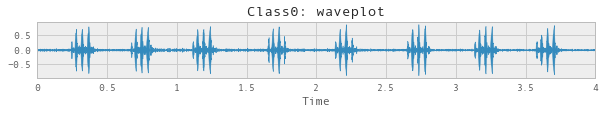

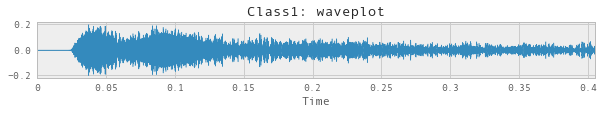

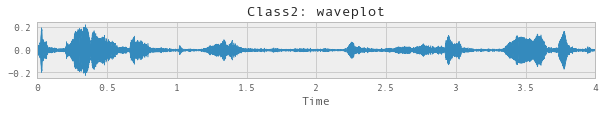

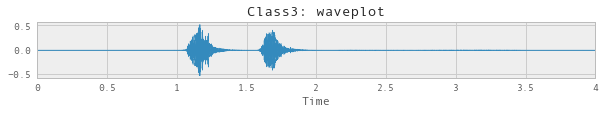

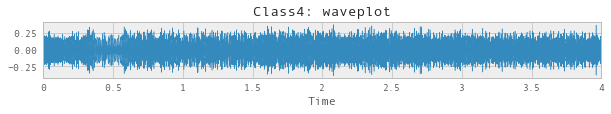

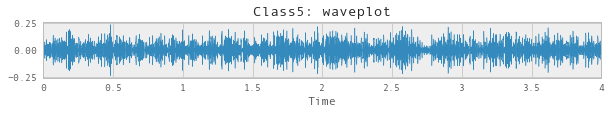

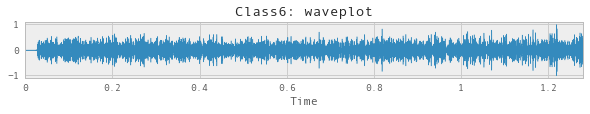

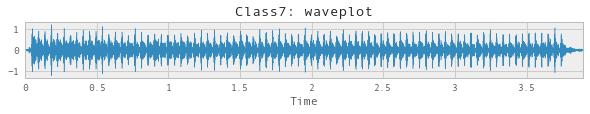

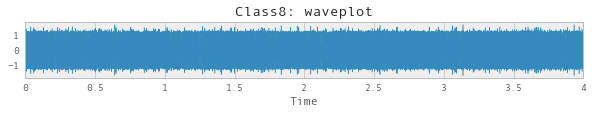

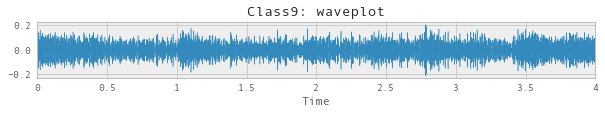

In [367]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import shutil
import random

ex_name=["90-0.wav","11-1.wav","61-2.wav","419-3.wav","1217-4.wav","1023-5.wav","1434-6.wav","1967-7.wav","1419-8.wav","1073-9.wav"]
i=0

for i in range(len(ex_name)):
    y, sr = librosa.load('./Train/'+ex_name[i])
    plt.figure(figsize=(10,15))
    plt.subplot(len(ex_name), 1, i+1)
    librosa.display.waveplot(y, sr=sr)
    plt.title("Class"+ex_name[i][-5]+": waveplot")
    

We can see that it may be difficult to differentiate between Class 4 and Class 8. But how is the difference between the class? 

In [370]:
def withclass(ex_name):
    i=0
    plt.figure(figsize=(15,3))

    for i in range(len(ex_name)):
        y, sr = librosa.load('./Train/'+ex_name[i])    
        plt.subplot(1,len(ex_name), i+1)
        librosa.display.waveplot(y, sr=sr)
        plt.title(ex_name[i])
    

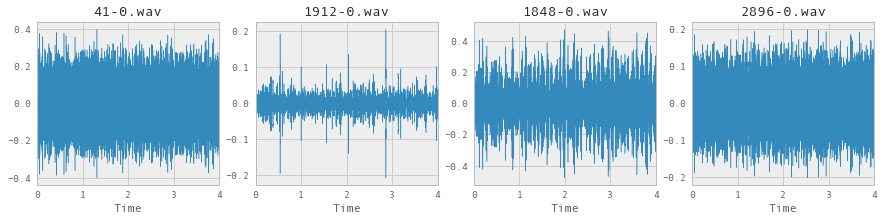

In [371]:
withclass(["41-0.wav","1912-0.wav","1848-0.wav","2896-0.wav"])

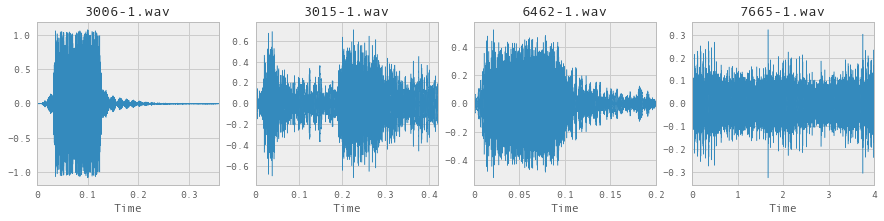

In [372]:
withclass(["3006-1.wav","3015-1.wav","6462-1.wav","7665-1.wav"])

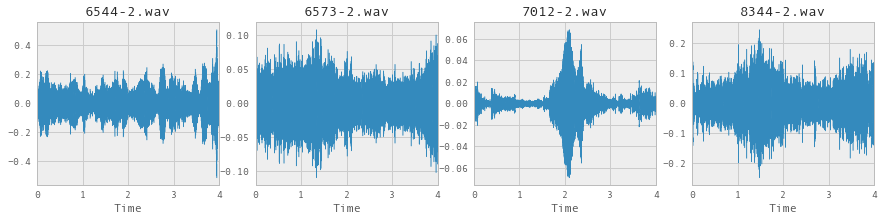

In [373]:
withclass(["6544-2.wav","6573-2.wav","7012-2.wav","8344-2.wav"])

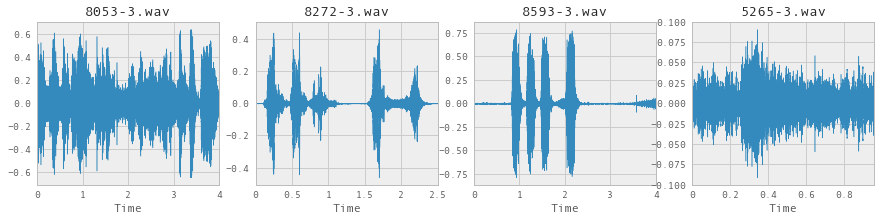

In [374]:
withclass(["8053-3.wav","8272-3.wav","8593-3.wav","5265-3.wav"])

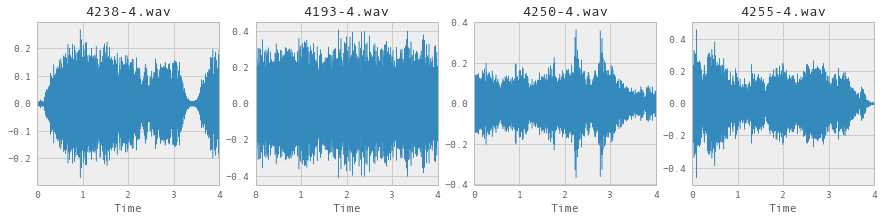

In [375]:
withclass(["4238-4.wav","4193-4.wav","4250-4.wav","4255-4.wav"])

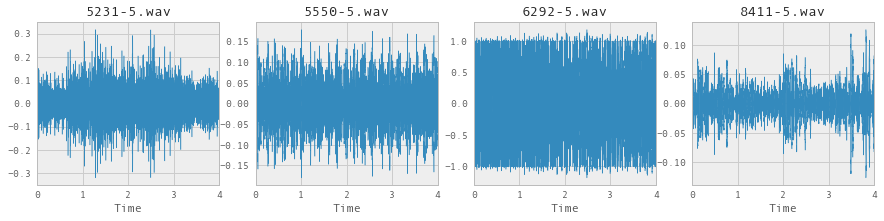

In [376]:
withclass(["5231-5.wav","5550-5.wav","6292-5.wav","8411-5.wav"])

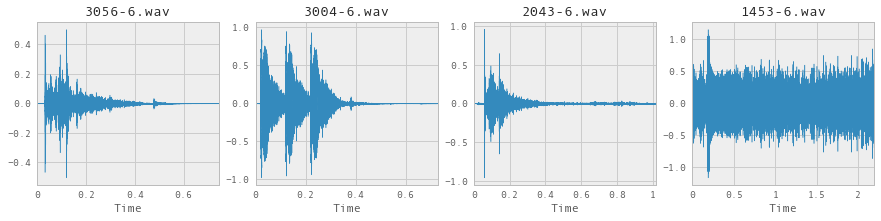

In [377]:
withclass(["3056-6.wav","3004-6.wav","2043-6.wav","1453-6.wav"])

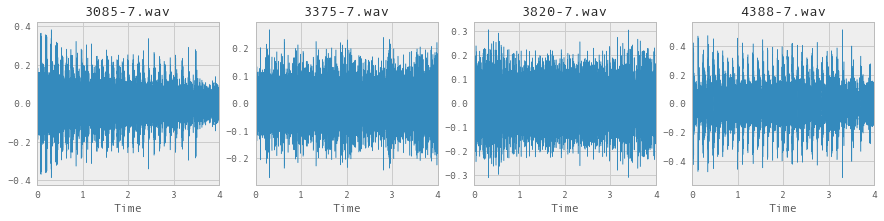

In [378]:
withclass(["3085-7.wav","3375-7.wav","3820-7.wav","4388-7.wav"])

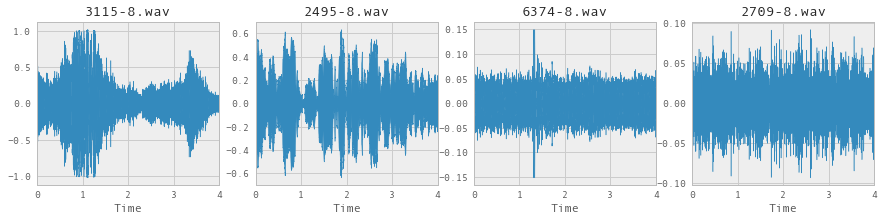

In [379]:
withclass(["3115-8.wav","2495-8.wav","6374-8.wav","2709-8.wav"])

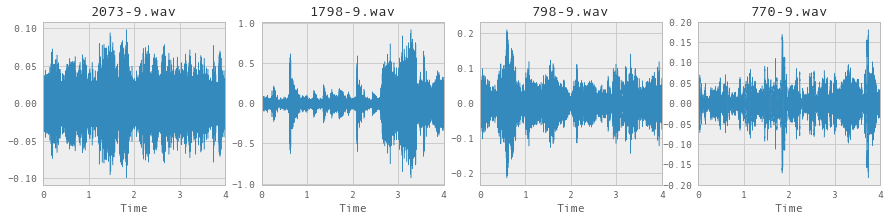

In [380]:
withclass(["2073-9.wav","1798-9.wav","798-9.wav","770-9.wav"])

The sample dataset is quite consistent in intra-class characteristics. Separability between classes is also quite good with this smaller dataset. We have some general groups of sounds:

* some of them with meaningful temporal structures (class 3),
* sound events with a lot of harmonic content (class 6),

**We can hypothesize that the main difficulty in classifying will be to discern inside rest of the groups.**


# 3. Feature Extraction

To extract the useful features from sound data, we will use Librosa library. It provides several methods to extract different features from the sound clips. We are going to use below mentioned methods to extract various features:

* **mfcc**: Mel-frequency cepstral coefficients. MFCCs are ubiquitous in speech processing and analyzing harmonic content. They may be less suitable for more noise-like environmental sounds, but the goal here is to get a general feel for the characteristics of the dataset, without striving for maximum classification accuracy.

* **chorma-stft**: Compute a chromagram from a waveform or power spectrogram.

So, first thing worth doing is to look at the distribution of the computed baseline features.
Let's begin by looking at 3 single clips (643-5.wav, 8272-3.wav, 3056-6.wav)/ all features perspective:


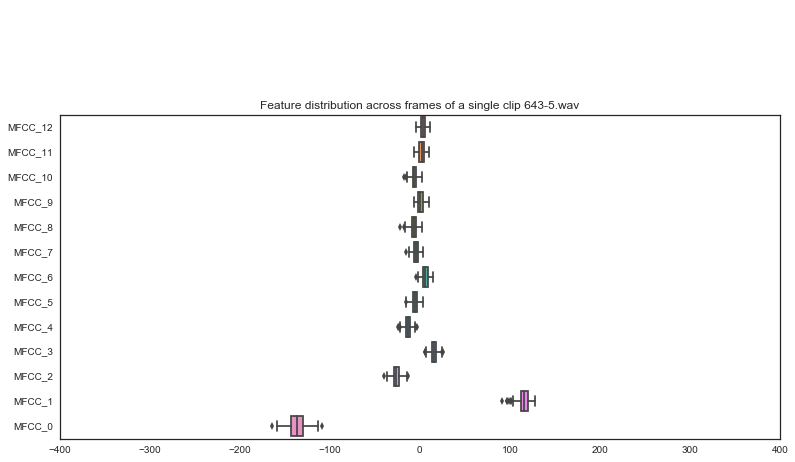

In [382]:
import seaborn as sb
import pandas as pd

sb.set(style="white", palette="muted")

def mfcc_plot(filename):
    X, sample_rate = librosa.load("./Train/"+filename)
    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13).T

    col_names = list('MFCC_{}'.format(i) for i in range(np.shape(mfccs)[1]))
    MFCC = pd.DataFrame(mfccs[:, :], columns=col_names)

    f = plt.figure(figsize=(10, 6))
    ax = f.add_axes([0.0, 0.0, 1.0, 1.0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    ax_mfcc = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.75])
    ax_mfcc.set_xlim(-400, 400)

    sb.boxplot(MFCC, vert=False, order=list(reversed(MFCC.columns)), ax=ax_mfcc)

    plt.title('Feature distribution across frames of a single clip '+filename)

mfcc_plot("643-5.wav")   

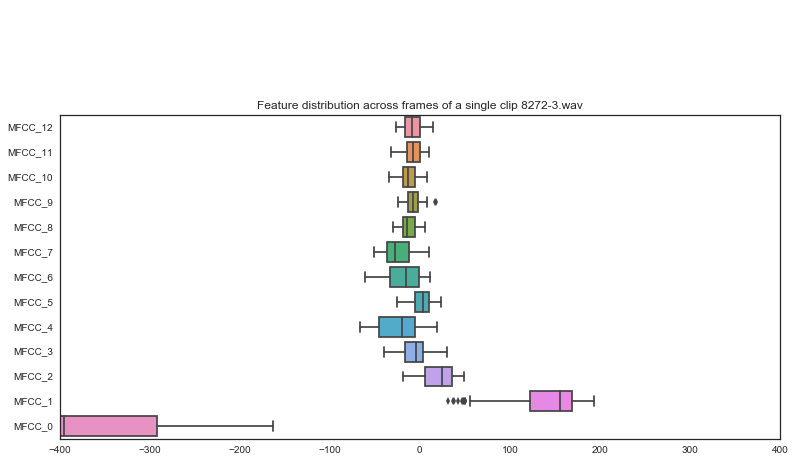

In [383]:
mfcc_plot("8272-3.wav") 

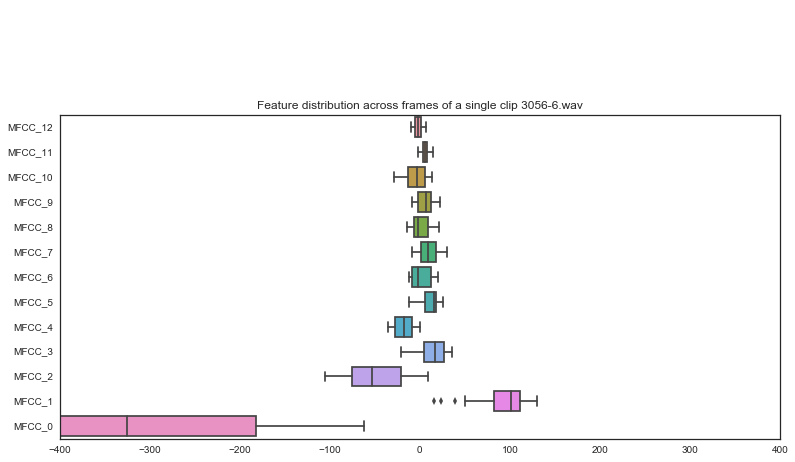

In [384]:
mfcc_plot("3056-6.wav") 

We will not be paying too much attention to the 0th MFCC, as it's not very interesting (derived from the whole log-spectrum).

Looking at the plot, we can see that even with a single clip, the dispersion of initial coefficients (MFCC1,MFCC2) is quite high. This is to be expected, as most information should have become compressed in first DCT coefficients (an underlying transform used to compute final MFCC values).

This way we can now concentrate our exploration on MFCC1,MFCC2 with an all clips / single feature analysis. The last thing we could do right now is to look at class separability when taking solely MFCC1 and MFCC2 into consideration. This way it will be easy to represent this as a 2D scatter plot:

In [385]:
#Extract and return features
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    
    stft = np.abs(librosa.stft(X))
    mfccs_mean = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=3).T,axis=0)
    return mfccs_mean


#takes parent directory name, subdirectories within parent directory and file extension (default is .wav) as input
def parse_audio_files(parent_dir,sub_dir,file_ext="*.wav"):
    features, labels = np.empty((0,3)), np.empty(0)

    for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
        try:
          mfccs_mean= extract_feature(fn)
        except Exception as e:
          print "Error encountered while parsing file: ", fn
          continue      
        
        ext_features = [mfccs_mean]
        features = np.vstack([features,ext_features])
        labels = np.append(labels, fn.split('/')[-1][-5]) 
        
    return np.array(features), np.array(labels, dtype = np.int)


parent_dir = "./"
tr_sub_dirs = "Train"
tr_features, tr_labels = parse_audio_files(parent_dir,tr_sub_dirs)

In [386]:
clip_features = pd.DataFrame({"label":tr_labels})
clip_features["MFCC_1mean"]=tr_features[:,1]
clip_features["MFCC_2mean"]=tr_features[:,2]
clip_features["label_name"]=clip_features["label"]

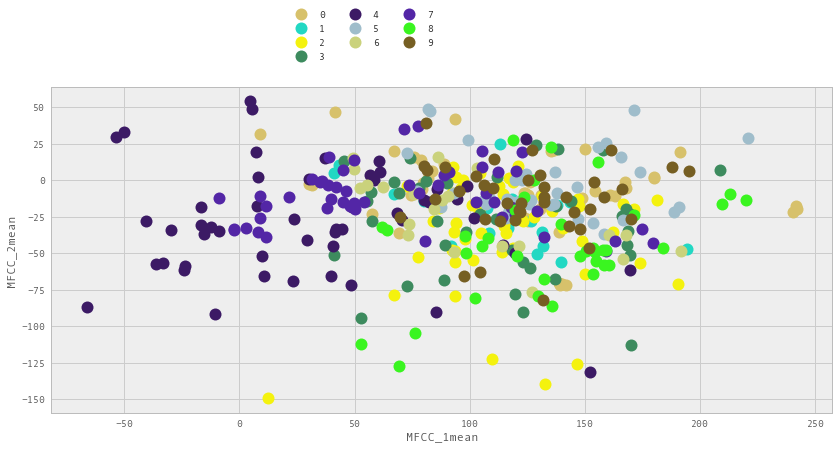

In [387]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

clip_features = pd.DataFrame({"label":tr_labels})
clip_features["MFCC_1mean"]=tr_features[:,1]
clip_features["MFCC_2mean"]=tr_features[:,2]

groups = clip_features.groupby('label')


# Plot
plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
colors = pd.tools.plotting._get_standard_colors(len(groups), color_type='random')

fig, ax = plt.subplots(figsize=(14, 6))
ax.set_color_cycle(colors)
ax.margins(0.05)

for name, group in groups:
    ax.plot(group["MFCC_1mean"], group["MFCC_2mean"], marker='o', linestyle='', ms=12, label=name)
ax.legend(loc='lower right', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
ax.set_xlabel("MFCC_1mean")
ax.set_ylabel("MFCC_2mean")

plt.show()

Although we're looking at only two variables at a time (mean values of MFCC1 with MFCC2), some patterns emerge. Solely with this information we could certainly catch most **Class7** (based on high MFCC2 and lower MFCC1 cutoff).

**Still, this is based on only 2 variables in total. For sure, looking at our feature set, they are the most informative ones. But I believe we can capture more information with approach to dimensionality reduction (e.g. principal component analysis (PCA)).**

# 4. Classification with machine learning techniques

We will begin by using some standard machine learning classifiers on the train dataset. Features (MFCCs and chorma-stft) will be summarized for each clip with their mean.

In [388]:
import glob
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
%matplotlib inline

############################
####Feature Extraction######
#Extract and return features
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=10).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    
    return mfccs,chroma


#takes parent directory name, subdirectories within parent directory and file extension (default is .wav) as input
def parse_audio_files(parent_dir,sub_dir,file_ext="*.wav"):
    features, labels = np.empty((0,22)), np.empty(0)

    for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
        try:
          mfccs,chroma= extract_feature(fn)
        except Exception as e:
          print "Error encountered while parsing file: ", fn
          continue      
        
        ext_features = np.hstack([mfccs,chroma])
        features = np.vstack([features,ext_features])
        labels = np.append(labels, fn.split('/')[-1][-5]) 
        
    return np.array(features), np.array(labels, dtype = np.int)


In [389]:
parent_dir = "./"

tr_sub_dirs = "Train"
ts_sub_dirs = "Test"

tr_features, tr_labels = parse_audio_files(parent_dir,tr_sub_dirs)
ts_features, ts_labels = parse_audio_files(parent_dir,ts_sub_dirs)


/anaconda/lib/python2.7/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


Let's check whether we have load audio files and extract features.

In [390]:
print len(tr_features)
print len(ts_features)
tr_features.shape

400
80


(400, 22)

## Basic Model

In this example 5 popular classifiers are used: k-nearest neighbors, random forest and SVM (support vector machine),extra trees and decision trees.


In [391]:
import sklearn as sk
import sklearn.ensemble

x = tr_features
y = tr_labels

val_x = ts_features
val_y = ts_labels
test = pd.DataFrame({"label":val_y})


def to_percentage(number):
    return int(number * 1000) / 10.0

def classify(classifier='knn', PCA=False, debug=False):
    results = []
    
    if classifier == 'knn':
        classifier_name = 'k-NN'
        knn = sk.neighbors.KNeighborsClassifier(n_neighbors=5)
        knn.fit(x,y)
        test.loc[:, 'prediction'] = knn.predict(val_x)
        
    if classifier == 'rf':
            classifier_name = 'Random Forest'
            rf = sk.ensemble.RandomForestClassifier(n_estimators=500, random_state=20180108)
            rf.fit(x,y)
            test.loc[:, 'prediction'] = rf.predict(val_x)
            
    if classifier == 'svm':
        classifier_name = 'Support Vector Machine (SVM)'
        svm = sk.svm.SVC(C=0.1, kernel='linear', random_state=20180109)
        svm.fit(x,y)
        test.loc[:, 'prediction'] = svm.predict(val_x)
        
    if classifier == 'extra_trees':
        classifier_name = 'Extra Trees'
        extra_trees = sk.ensemble.ExtraTreesClassifier(n_estimators=500, random_state=20180109)
        extra_trees.fit(x,y)
        test.loc[:, 'prediction'] = extra_trees.predict(val_x)
        
    if classifier == 'decision_trees':
        classifier_name = 'Decision Trees'
        decision_trees = sk.tree.DecisionTreeClassifier(max_depth=10, random_state=20180109)
        decision_trees.fit(x,y)
        test.loc[:, 'prediction'] = decision_trees.predict(val_x)
        
    accuracy = np.sum(test['label'] == test['prediction']) / float(len(test['label']))
    results.append(accuracy)

    print 'Classifying with {0} classifier. Accuracy: {1}%'.format(classifier_name, to_percentage(accuracy))



In [392]:
classify('knn')
classify('rf')
classify('svm')
classify('extra_trees')
classify('decision_trees')

Classifying with k-NN classifier. Accuracy: 46.2%
Classifying with Random Forest classifier. Accuracy: 67.5%
Classifying with Support Vector Machine (SVM) classifier. Accuracy: 47.5%
Classifying with Extra Trees classifier. Accuracy: 62.5%
Classifying with Decision Trees classifier. Accuracy: 33.7%


Learning on the train dataset with testing on test dataset results in average accuracies ranging from 46.2% for the k-NN classifier, 67.5% with random forest ensemble, 47.5%(SVM), 62.5% with Extra Trees and 33.7% with decision tree. 

This is to be expected with such small train dataset.One way to tackle this issue could be to **train on whole dataset (8377 recordings)** or use **cross-validation** for each experiment. 

##  Deep Learning Model

In [393]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

X = tr_features
y = tr_labels

val_x = ts_features
val_y = ts_labels

lb = LabelEncoder()

y = np_utils.to_categorical(lb.fit_transform(y))

val_y=  np_utils.to_categorical(lb.fit_transform(val_y))

In [394]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = y.shape[1]
filter_size = 2

# build model
model = Sequential()

model.add(Dense(256, input_shape=(22,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [395]:
model.fit(X, y, batch_size=32, epochs=5, validation_data=(val_x, val_y))

Train on 400 samples, validate on 80 samples
Epoch 1/5
400/400 [==============================] - 1s 1ms/step - loss: 12.6614 - acc: 0.1275 - val_loss: 8.5789 - val_acc: 0.1250
Epoch 2/5
400/400 [==============================] - 0s 134us/step - loss: 12.2830 - acc: 0.1525 - val_loss: 10.7785 - val_acc: 0.2250
Epoch 3/5
400/400 [==============================] - 0s 163us/step - loss: 11.8337 - acc: 0.1675 - val_loss: 12.9572 - val_acc: 0.1625
Epoch 4/5
400/400 [==============================] - 0s 155us/step - loss: 12.0938 - acc: 0.1650 - val_loss: 10.6476 - val_acc: 0.2125
Epoch 5/5
400/400 [==============================] - 0s 189us/step - loss: 11.9433 - acc: 0.1775 - val_loss: 7.6303 - val_acc: 0.3250


The accuracy is even lower than random guess. The score can be increased obviously. I think I need more time to improve the parameter.

# Future steps to explore
1. Extract more useful features, such as **spectral contrast** (Compute spectral contrast, using method defined in [1](http://ieeexplore.ieee.org/document/1035731/)), and **tonnetz**(Computes the tonal centroid features (tonnetz), following the method of [2](https://dl.acm.org/citation.cfm?id=1178727)).
2. Build more efficient models, such as **convolutional neural networks** or **recurrent neural networks**. 
3. Evaluate deep neural networks and other deep learning (preferably generative) models in this context, e.g. with **unsupervised pre-training**.
 